In [43]:
import scipy.stats as ss
import  scipy.optimize as so
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.spatial import Delaunay
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from pricing_model import BlackScholesPricer
from openbb import obb
import polars as pl

In [3]:
treasury_data = obb.economy.interest_rates(country="USA", maturity="10Y").to_df()
free_rate = treasury_data["value"].iloc[-1]   # Convertir en décimal


In [17]:
obb.economy.interest_rates(provider='oecd').to_df()
obb.derivatives.options.chains(symbol="AAPL").to_df()

,underlying_symbol,underlying_price,contract_symbol,expiration,dte,strike,option_type,open_interest,volume,last_trade_price,last_trade_time,bid,ask,change,change_percent,implied_volatility,in_the_money,currency
0,AAPL,260.33,AAPL260109P00110000,2026-01-09,1,110.0,put,4,0,0.01,2026-01-06 11:13:41-05:00,NaN,0.0,0.0,0.0,0.500005,False,USD
1,AAPL,260.33,AAPL260109C00120000,2026-01-09,1,120.0,call,4,4,141.21,2026-01-07 15:33:25-05:00,0.0,0.0,0.0,0.0,0.000010,True,USD
2,AAPL,260.33,AAPL260109P00130000,2026-01-09,1,130.0,put,1,0,0.01,2026-01-06 11:05:50-05:00,NaN,0.0,0.0,0.0,0.500005,False,USD
3,AAPL,260.33,AAPL260109P00135000,2026-01-09,1,135.0,put,1655,1650,0.01,2026-01-07 15:57:19-05:00,0.0,0.0,0.0,0.0,0.500005,False,USD
4,AAPL,260.33,AAPL260109P00140000,2026-01-09,1,140.0,put,6,1,0.06,2026-01-07 09:39:04-05:00,0.0,0.0,0.0,0.0,0.500005,False,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,AAPL,260.33,AAPL280317C00520000,2028-03-17,799,520.0,call,6,12,3.15,2026-01-02 10:52:48-05:00,0.0,0.0,0.0,0.0,0.062509,False,USD
2326,AAPL,260.33,AAPL280317C00530000,2028-03-17,799,530.0,call,35,1,2.57,2026-01-05 12:31:33-05:00,0.0,0.0,0.0,0.0,0.125009,False,USD
2327,AAPL,260.33,AAPL280317C00540000,2028-03-17,799,540.0,call,103,41,2.14,2026-01-06 15:45:08-05:00,0.0,0.0,0.0,0.0,0.125009,False,USD
2328,AAPL,260.33,AAPL280317C00550000,2028-03-17,799,550.0,call,852,242,1.90,2026-01-07 15:57:29-05:00,0.0,0.0,0.0,0.0,0.125009,False,USD


In [ ]:
class IvBlackScholes:
    def __init__(self, ticker, free_rate):
        self.ticker = ticker
        self.data = obb.equity.price.historical(symbol=self.ticker).to_df()
        self.options = obb.derivatives.options.chains(symbol=self.ticker).to_df()
        self.free_rate = free_rate
        self.spot_price = self.data['close'].iloc[-1]
        self.processed_options = self.preprocessing()
        self.market_data = self.apply_kernel()
        self.interpolated_surface = None
        self.cordonates = {}

    def preprocessing(self):
        df = self.options.copy()
        df['time_to_expiry'] = (pd.to_datetime(df['expiration']) - pd.to_datetime(df.get('as_of_date', pd.Timestamp.today()))).dt.days / 365
        df_filtered = df[df["time_to_expiry"] > 0.25].reset_index(drop=True)
        price_col = 'last_trade_price' if 'last_trade_price' in df_filtered.columns else ('lastPrice' if 'lastPrice' in df_filtered.columns else None)
        if price_col is None:
            raise KeyError("Prix marché introuvable (pas de 'last_trade_price' ni 'lastPrice')")
        df_option = df_filtered.groupby(["strike", "time_to_expiry"], as_index=False).first()[["strike", "time_to_expiry","option_type", price_col, "implied_volatility"]]
        df_option = df_option.rename(columns={price_col: "market_price"})
        return df_option

    def get_implied_vol(self, strike, time_to_expiry, market_price, option_type):
        def objective_function(volatility):
            pricer = BlackScholesPricer(
                S0=self.spot_price,
                K=strike,
                T=time_to_expiry,
                sigma=volatility,
                r=self.free_rate,
            )
            model_price = pricer.price_call() if option_type == 'call' else pricer.price_put()
            return model_price - market_price
        vol_min, vol_max = 0.001, 3.0   
        try:
            f_min = objective_function(vol_min)
            f_max = objective_function(vol_max)

            if f_min * f_max <= 0:
                result = so.root_scalar(
                    objective_function,
                    bracket=[vol_min, vol_max],
                    method='brentq',
                    xtol=1e-8
                )
                return result.root
            else:
                result = so.minimize_scalar(
                    lambda x: objective_function(x)**2,
                    bounds=(vol_min, vol_max),
                    method='bounded'
                )
                return result.x
                
        except:
            return np.nan

    def apply_kernel(self):
        df = self.processed_options.copy()
        df['implied_vol'] = df.apply(
            lambda row: self.get_implied_vol(row['strike'], row['time_to_expiry'], row['market_price'], row['option_type']),
            axis=1
        )
        return df.assign(spot_price=self.spot_price).assign(moyeness=lambda x: x['strike'] / x['spot_price'])

    def interpolate_surface_multimethod(self, grid_size=50):
        """
        Interpole la surface de volatilité en utilisant plusieurs méthodes
        et choisit la meilleure
        """
        if self.market_data is None or len(self.market_data) < 10:
            print("Pas assez de données pour l'interpolation")
            return None
        
        df = self.market_data.copy()
        
        x_min, x_max = df['strike'].min(), df['strike'].max()
        y_min, y_max = df['time_to_expiry'].min(), df['time_to_expiry'].max()
        
        x_padding = (x_max - x_min) * 0.1
        y_padding = (y_max - y_min) * 0.1
        
        x_grid = np.linspace(max(0, x_min - x_padding), x_max + x_padding, grid_size)
        y_grid = np.linspace(max(0.01, y_min - y_padding), y_max + y_padding, grid_size)
        X, Y = np.meshgrid(x_grid, y_grid)
        
        points = df[['strike', 'time_to_expiry']].values
        values = df['implied_vol'].values
        print("Interpolation RBF...")
        try:
            rbf = interpolate.RBFInterpolator(points, values, kernel='thin_plate_spline')
            grid_points = np.column_stack((X.ravel(), Y.ravel()))
            Z_rbf = rbf(grid_points).reshape(X.shape)
        except:
            Z_rbf = np.full(X.shape, np.nan)
        
        # Méthode 2: Interpolation linéaire
        print("Interpolation linéaire...")
        tri = Delaunay(points)
        interp_linear = interpolate.LinearNDInterpolator(tri, values)
        Z_linear = interp_linear(X, Y)
        
        # Méthode 3: Interpolation par splines bi-cubiques
        print("Interpolation par splines...")
        try:
            # Rééchantillonnage sur une grille régulière pour les splines
            x_unique = np.unique(points[:, 0])
            y_unique = np.unique(points[:, 1])
            
            if len(x_unique) > 3 and len(y_unique) > 3:
                # Création d'une grille irrégulière pour interpolation
                interp_spline = interpolate.griddata(points, values, (X, Y), 
                                                   method='cubic', fill_value=np.nan)
                Z_spline = interp_spline
            else:
                Z_spline = np.full(X.shape, np.nan)
        except:
            Z_spline = np.full(X.shape, np.nan)
        
        Z_combined = np.copy(Z_linear)
        
        nan_mask = np.isnan(Z_combined)
        if not np.all(np.isnan(Z_rbf)):
            Z_combined[nan_mask] = Z_rbf[nan_mask]
        
        # Remplir les NaN restants avec spline
        nan_mask = np.isnan(Z_combined)
        if not np.all(np.isnan(Z_spline)):
            Z_combined[nan_mask] = Z_spline[nan_mask]
        
        # Lissage supplémentaire
        from scipy.ndimage import gaussian_filter
        Z_smoothed = gaussian_filter(Z_combined, sigma=1.0)
        
        # Limites de volatilité
        Z_smoothed = np.clip(Z_smoothed, 0.01, 1.5)
        
        self.interpolated_surface = {
            'strikes_grid': x_grid,
            'maturities_grid': y_grid,
            'strike_grid_2d': X,
            'maturity_grid_2d': Y,
            'volatility_grid': Z_smoothed,
            'original_points': points,
            'original_values': values
        }
        
        print("Interpolation terminée")
        return self.interpolated_surface



In [63]:
test = IvBlackScholes("AAPL", free_rate)

In [64]:
data  = test.interpolate_surface_multimethod()

Interpolation RBF...
Interpolation linéaire...
Interpolation par splines...
Interpolation terminée


In [65]:
cords = test.cordonates

In [80]:
points = cords["points"]
x_grid = cords["x_grid"]
y_grid = cords["y_grid"]
implied_vols = cords["implied_vols"]   
X,Y = np.meshgrid(x_grid, y_grid)
strikes = points[:, 0]
maturities = points[:, 1]
grid_points = np.column_stack((X.ravel(), Y.ravel()))
rbf = interpolate.RBFInterpolator(points, implied_vols, kernel='thin_plate_spline') 
rbf

In [79]:
grid_points = np.column_stack((X.ravel(), Y.ravel()))

TypeError: RBFInterpolator.__call__() takes 2 positional arguments but 3 were given

Chargement des données de marché pour AAPL...
Prix spot: 260.3299865722656
Source de prix utilisée: last_trade_price
Volatilité implicite disponible dans les données
Données traitées: 1056 points
Plage de strikes: 5.00 - 550.00
Plage de maturités: 0.019 - 2.185 ans
Plage de volatilité: 0.016 - 1.935

Détection et remplissage des trous...
Points disponibles: 109 strikes × 19 maturités
Points ajoutés: 917

Interpolation de la surface...
Interpolation RBF...
Interpolation linéaire...
Interpolation par splines...
Interpolation terminée

Génération des visualisations...


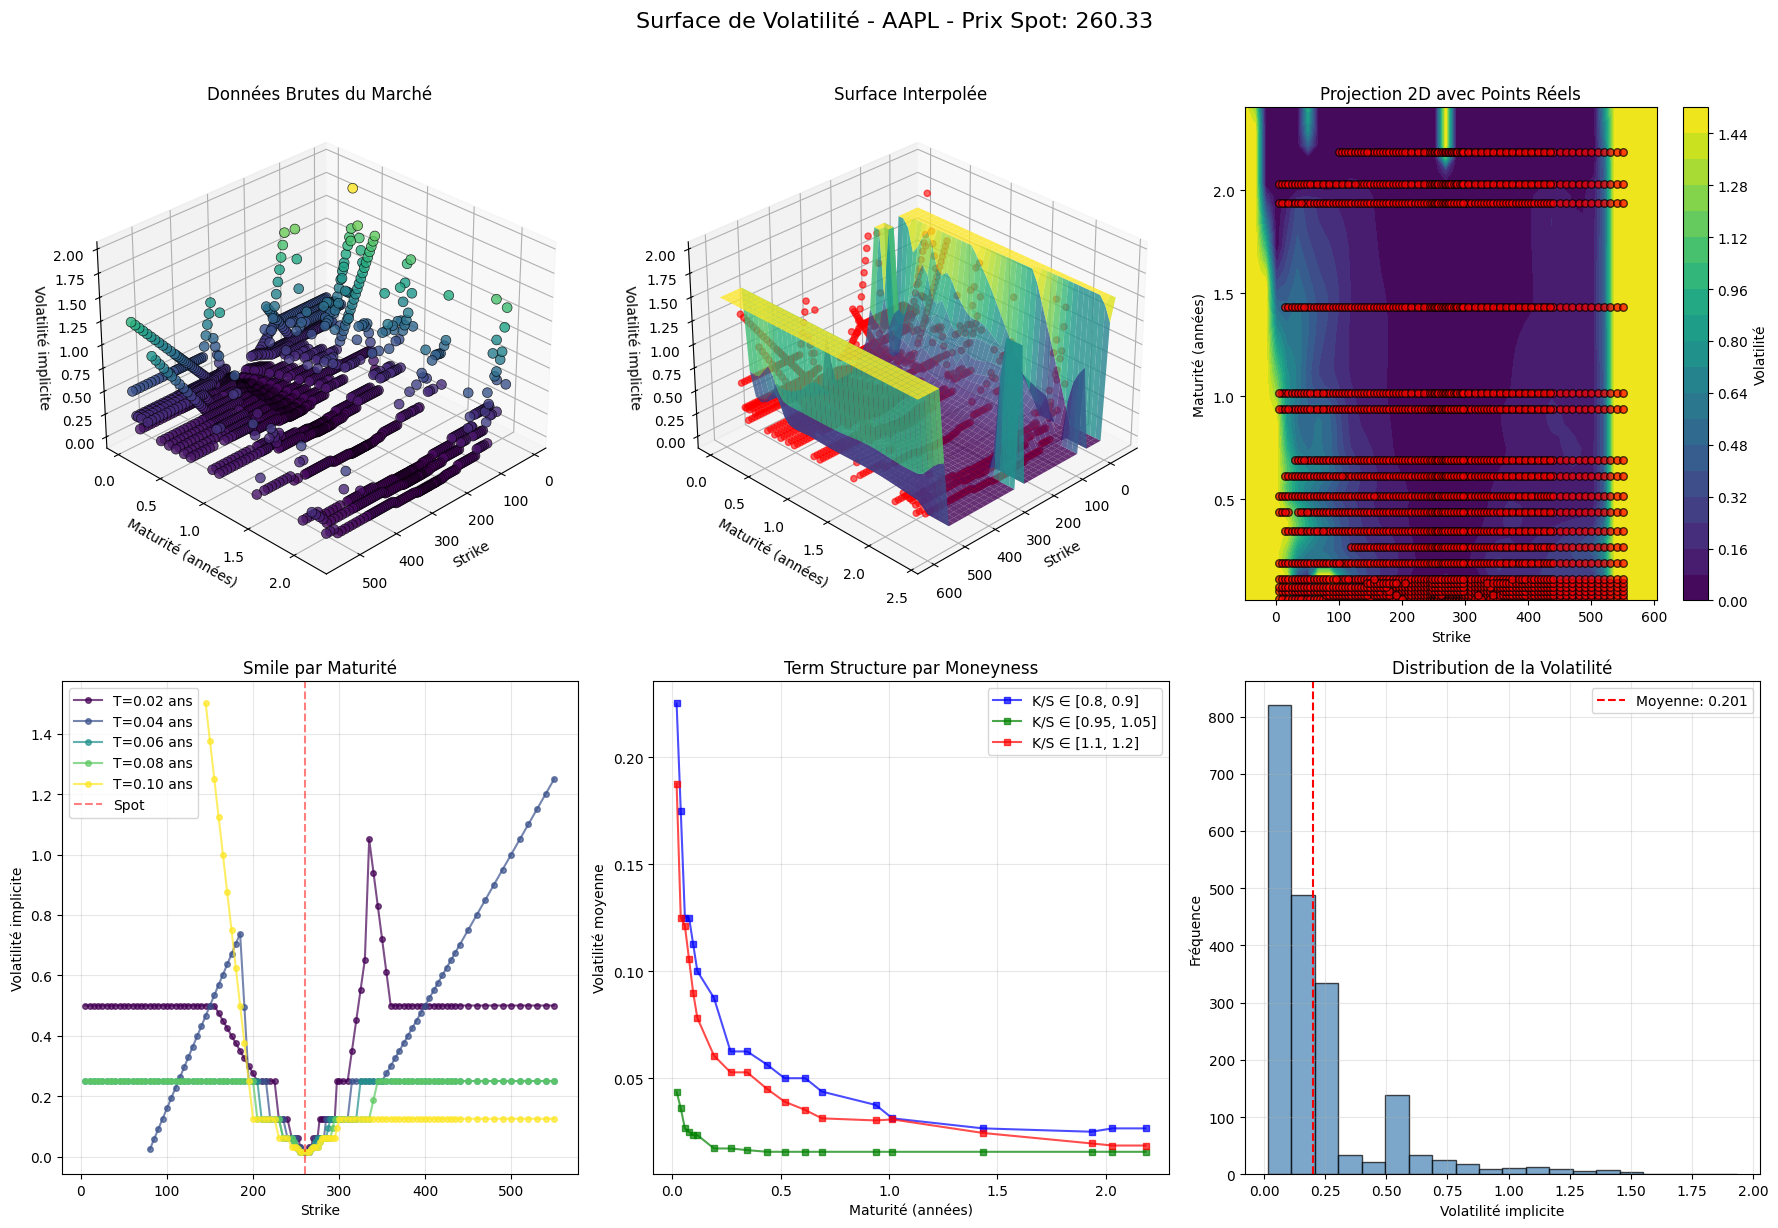


Export des données...
Surface exportée vers: volatility_surface_AAPL_20260108_131118.csv
Points exportés: 1600

STATISTIQUES DE LA SURFACE
Prix spot: 260.33
Nombre de points de données: 1973
Plage de strikes: 5.00 - 550.00
Plage de maturités: 0.019 - 2.185 ans
Volatilité moyenne: 0.201
Volatilité min/max: 0.016 / 1.935


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import interpolate
from scipy import optimize as so
from scipy.stats import norm
from scipy.spatial import Delaunay
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

class MarketVolatilitySurface3D:
    def __init__(self, ticker, free_rate=0.03, use_api=True):
        """
        Classe pour calculer et visualiser la surface de volatilité avec données réelles
        
        Args:
            ticker: Symbole de l'action
            free_rate: Taux sans risque
            use_api: Si True, utilise l'API pour les données réelles
        """
        self.ticker = ticker
        self.free_rate = free_rate
        self.spot_price = None
        self.market_data = None
        self.surface_data = None
        self.interpolated_surface = None
        
        if use_api:
            self.load_market_data()
    
    def load_market_data(self):
        """
        Charge les données de marché réelles depuis l'API
        """
        print(f"Chargement des données de marché pour {self.ticker}...")
        
        try:
            # Prix spot
            price_data = obb.equity.price.historical(symbol=self.ticker).to_df()
            self.spot_price = price_data['close'].iloc[-1]
            print(f"Prix spot: {self.spot_price}")
            
            # Chaînes d'options
            options_data = obb.derivatives.options.chains(symbol=self.ticker).to_df()
            
            # Prétraitement des données
            self.process_market_data(options_data)
            
        except Exception as e:
            print(f"Erreur lors du chargement des données: {e}")
            print("Utilisation de données synthétiques en fallback...")
            self.create_synthetic_data()
    
    def process_market_data(self, options_df):
        """
        Prétraite les données d'options réelles
        """
        df = options_df.copy()
        
        # Nettoyage des colonnes
        if 'as_of_date' in df.columns:
            as_of_date = pd.to_datetime(df['as_of_date'].iloc[0])
        else:
            as_of_date = pd.Timestamp.now()
        
        # Conversion des dates
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['time_to_expiry'] = (df['expiration'] - as_of_date).dt.days / 365.25
        
        # Sélection du prix de marché
        price_sources = ['last_trade_price', 'lastPrice', 'mid_price', 'close']
        market_price_found = False
        
        for source in price_sources:
            if source in df.columns:
                df['market_price'] = df[source]
                market_price_found = True
                print(f"Source de prix utilisée: {source}")
                break
        
        if not market_price_found and 'bid' in df.columns and 'ask' in df.columns:
            df['market_price'] = (df['bid'] + df['ask']) / 2
            market_price_found = True
            print("Prix mid bid-ask utilisé")
        
        if not market_price_found:
            raise ValueError("Aucune source de prix valide trouvée")
        
        # Filtrage des données
        df = df[
            (df['time_to_expiry'] > 0.01) &  # Au moins 4 jours
            (df['time_to_expiry'] < 3.0) &   # Moins de 3 ans
            (df['market_price'] > 0.01) &    # Prix > 0.01
            (df['strike'] > 0)               # Strike positif
        ].copy()
        
        # Calcul du moneyness
        df['moneyness'] = df['strike'] / self.spot_price
        
        # Calcul de la volatilité implicite si non disponible
        if 'implied_volatility' in df.columns:
            df['implied_vol'] = df['implied_volatility']
            print("Volatilité implicite disponible dans les données")
        else:
            print("Calcul de la volatilité implicite...")
            df['implied_vol'] = df.apply(
                lambda row: self.calculate_implied_volatility(
                    self.spot_price,
                    row['strike'],
                    row['time_to_expiry'],
                    row['market_price'],
                    row.get('option_type', 'call')
                ),
                axis=1
            )
        
        # Filtrage des volatilités aberrantes
        df = df[
            (df['implied_vol'] > 0.01) & 
            (df['implied_vol'] < 2.0)
        ].copy()
        
        # Agrégation pour éviter les doublons
        df = df.groupby(['strike', 'time_to_expiry']).agg({
            'implied_vol': 'mean',
            'moneyness': 'first',
            'market_price': 'mean'
        }).reset_index()
        
        self.market_data = df
        print(f"Données traitées: {len(df)} points")
        print(f"Plage de strikes: {df['strike'].min():.2f} - {df['strike'].max():.2f}")
        print(f"Plage de maturités: {df['time_to_expiry'].min():.3f} - {df['time_to_expiry'].max():.3f} ans")
        print(f"Plage de volatilité: {df['implied_vol'].min():.3f} - {df['implied_vol'].max():.3f}")
        
        return df
    
    def calculate_implied_volatility(self, S, K, T, market_price, option_type='call'):
        """
        Calcule la volatilité implicite
        """
        if T <= 0 or market_price <= 0:
            return np.nan
        
        def black_scholes_price(sigma):
            d1 = (np.log(S / K) + (self.free_rate + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            
            if option_type == 'call':
                return S * norm.cdf(d1) - K * np.exp(-self.free_rate * T) * norm.cdf(d2)
            else:
                return K * np.exp(-self.free_rate * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        
        def objective(sigma):
            return black_scholes_price(sigma) - market_price
        
        # Recherche de la volatilité
        vol_min, vol_max = 0.001, 3.0
        
        try:
            # Vérification des bornes
            f_min = objective(vol_min)
            f_max = objective(vol_max)
            
            if f_min * f_max <= 0:
                result = so.root_scalar(
                    objective, 
                    bracket=[vol_min, vol_max],
                    method='brentq',
                    xtol=1e-8
                )
                return result.root
            else:
                # Fallback: minimisation
                result = so.minimize_scalar(
                    lambda x: objective(x)**2,
                    bounds=(vol_min, vol_max),
                    method='bounded'
                )
                return result.x
                
        except:
            return np.nan
    
    def create_synthetic_data(self):
        """
        Crée des données synthétiques si l'API échoue
        """
        print("Création de données synthétiques...")
        self.spot_price = 100
        
        # Création d'une grille avec des trous pour simuler les données réelles
        n_strikes = 15
        n_maturities = 10
        
        strikes = np.linspace(70, 130, n_strikes)
        maturities = np.linspace(0.1, 2.0, n_maturities)
        
        data = []
        
        for T in maturities:
            for K in strikes:
                # Création de trous aléatoires (30% de données manquantes)
                if np.random.random() > 0.7:
                    continue
                
                moneyness = K / self.spot_price
                
                # Surface de volatilité réaliste avec smile
                atm_vol = 0.25
                if moneyness < 0.9:
                    vol = atm_vol + (0.9 - moneyness) * 0.15
                elif moneyness > 1.1:
                    vol = atm_vol + (moneyness - 1.1) * 0.2
                else:
                    vol = atm_vol
                
                # Term structure
                vol = vol * (1 + 0.08 * np.sqrt(T))
                
                # Bruit
                vol = vol * (1 + np.random.normal(0, 0.03))
                vol = max(0.05, min(vol, 0.8))
                
                data.append({
                    'strike': K,
                    'time_to_expiry': T,
                    'moneyness': moneyness,
                    'implied_vol': vol
                })
        
        self.market_data = pd.DataFrame(data)
        print(f"Données synthétiques créées: {len(data)} points")
    
    def interpolate_surface_multimethod(self, grid_size=50):
        """
        Interpole la surface de volatilité en utilisant plusieurs méthodes
        et choisit la meilleure
        """
        if self.market_data is None or len(self.market_data) < 10:
            print("Pas assez de données pour l'interpolation")
            return None
        
        df = self.market_data.copy()
        
        # Création de la grille
        x_min, x_max = df['strike'].min(), df['strike'].max()
        y_min, y_max = df['time_to_expiry'].min(), df['time_to_expiry'].max()
        
        # Extension modérée de la grille
        x_padding = (x_max - x_min) * 0.1
        y_padding = (y_max - y_min) * 0.1
        
        x_grid = np.linspace(x_min - x_padding, x_max + x_padding, grid_size)
        y_grid = np.linspace(max(0.01, y_min - y_padding), y_max + y_padding, grid_size)
        X, Y = np.meshgrid(x_grid, y_grid)
        
        points = df[['strike', 'time_to_expiry']].values
        values = df['implied_vol'].values
        
        print("Interpolation RBF...")
        try:
            rbf = interpolate.Rbf(points[:, 0], points[:, 1], values,
                                function='thin_plate', smooth=0.1)
            Z_rbf = rbf(X, Y)
        except:
            Z_rbf = np.full(X.shape, np.nan)
        
        # Méthode 2: Interpolation linéaire
        print("Interpolation linéaire...")
        tri = Delaunay(points)
        interp_linear = interpolate.LinearNDInterpolator(tri, values)
        Z_linear = interp_linear(X, Y)
        
        # Méthode 3: Interpolation par splines bi-cubiques
        print("Interpolation par splines...")
        try:
            # Rééchantillonnage sur une grille régulière pour les splines
            x_unique = np.unique(points[:, 0])
            y_unique = np.unique(points[:, 1])
            
            if len(x_unique) > 3 and len(y_unique) > 3:
                # Création d'une grille irrégulière pour interpolation
                interp_spline = interpolate.griddata(points, values, (X, Y), 
                                                   method='cubic', fill_value=np.nan)
                Z_spline = interp_spline
            else:
                Z_spline = np.full(X.shape, np.nan)
        except:
            Z_spline = np.full(X.shape, np.nan)
        
        # Combinaison des méthodes (priorité: spline > RBF > linéaire)
        Z_combined = np.copy(Z_linear)
        
        # Remplir les NaN avec RBF
        nan_mask = np.isnan(Z_combined)
        if not np.all(np.isnan(Z_rbf)):
            Z_combined[nan_mask] = Z_rbf[nan_mask]
        
        # Remplir les NaN restants avec spline
        nan_mask = np.isnan(Z_combined)
        if not np.all(np.isnan(Z_spline)):
            Z_combined[nan_mask] = Z_spline[nan_mask]
        
        # Lissage supplémentaire
        from scipy.ndimage import gaussian_filter
        Z_smoothed = gaussian_filter(Z_combined, sigma=1.0)
        
        # Limites de volatilité
        Z_smoothed = np.clip(Z_smoothed, 0.01, 1.5)
        
        self.interpolated_surface = {
            'strikes_grid': x_grid,
            'maturities_grid': y_grid,
            'strike_grid_2d': X,
            'maturity_grid_2d': Y,
            'volatility_grid': Z_smoothed,
            'original_points': points,
            'original_values': values
        }
        
        print("Interpolation terminée")
        return self.interpolated_surface
    
    def detect_and_fill_gaps(self):
        """
        Détecte et comble les trous dans la surface
        """
        if self.market_data is None:
            return
        
        df = self.market_data.copy()
        
        # Création d'une grille des points disponibles
        strikes = np.sort(df['strike'].unique())
        maturities = np.sort(df['time_to_expiry'].unique())
        
        print(f"Points disponibles: {len(strikes)} strikes × {len(maturities)} maturités")
        
        # Détection des trous
        strike_step = np.median(np.diff(strikes))
        maturity_step = np.median(np.diff(maturities))
        
        filled_data = []
        
        # Pour chaque maturité, interpoler les strikes manquants
        for T in maturities:
            subset = df[df['time_to_expiry'] == T]
            
            if len(subset) > 1:
                # Interpolation 1D pour cette maturité
                interp_1d = interpolate.interp1d(
                    subset['strike'], subset['implied_vol'],
                    kind='linear', bounds_error=False, fill_value='extrapolate'
                )
                
                # Remplissage des strikes dans la plage
                for K in strikes:
                    if K not in subset['strike'].values:
                        vol = float(interp_1d(K))
                        if 0.01 < vol < 1.5:  # Vérification de plausibilité
                            filled_data.append({
                                'strike': K,
                                'time_to_expiry': T,
                                'moneyness': K / self.spot_price,
                                'implied_vol': vol,
                                'is_filled': True
                            })
        
        # Combinaison des données originales et remplies
        if filled_data:
            filled_df = pd.DataFrame(filled_data)
            df['is_filled'] = False
            combined_df = pd.concat([df, filled_df], ignore_index=True)
            
            print(f"Points ajoutés: {len(filled_df)}")
            self.market_data = combined_df
        
        return self.market_data
    
    def plot_surface_comparison(self, figsize=(16, 10)):
        """
        Visualise la comparaison entre données brutes et surface interpolée
        """
        if self.market_data is None or self.interpolated_surface is None:
            print("Veuillez d'abord charger et interpoler les données")
            return
        
        fig = plt.figure(figsize=figsize)
        
        # 1. Données brutes
        ax1 = fig.add_subplot(231, projection='3d')
        ax1.scatter(
            self.market_data['strike'],
            self.market_data['time_to_expiry'],
            self.market_data['implied_vol'],
            c=self.market_data['implied_vol'],
            cmap='viridis',
            s=50,
            alpha=0.8,
            edgecolors='black',
            linewidth=0.5
        )
        ax1.set_xlabel('Strike')
        ax1.set_ylabel('Maturité (années)')
        ax1.set_zlabel('Volatilité implicite')
        ax1.set_title('Données Brutes du Marché')
        ax1.view_init(elev=30, azim=45)
        
        # 2. Surface interpolée
        ax2 = fig.add_subplot(232, projection='3d')
        surf = ax2.plot_surface(
            self.interpolated_surface['strike_grid_2d'],
            self.interpolated_surface['maturity_grid_2d'],
            self.interpolated_surface['volatility_grid'],
            cmap='viridis',
            alpha=0.8,
            linewidth=0,
            antialiased=True
        )
        ax2.scatter(
            self.market_data['strike'],
            self.market_data['time_to_expiry'],
            self.market_data['implied_vol'],
            c='red', s=20, alpha=0.6
        )
        ax2.set_xlabel('Strike')
        ax2.set_ylabel('Maturité (années)')
        ax2.set_zlabel('Volatilité implicite')
        ax2.set_title('Surface Interpolée')
        ax2.view_init(elev=30, azim=45)
        
        # 3. Heatmap de la surface
        ax3 = fig.add_subplot(233)
        contour = ax3.contourf(
            self.interpolated_surface['strike_grid_2d'],
            self.interpolated_surface['maturity_grid_2d'],
            self.interpolated_surface['volatility_grid'],
            levels=20,
            cmap='viridis'
        )
        ax3.scatter(
            self.market_data['strike'],
            self.market_data['time_to_expiry'],
            c='red',
            s=30,
            alpha=0.7,
            edgecolors='black'
        )
        ax3.set_xlabel('Strike')
        ax3.set_ylabel('Maturité (années)')
        ax3.set_title('Projection 2D avec Points Réels')
        plt.colorbar(contour, ax=ax3, label='Volatilité')
        
        # 4. Smile pour différentes maturités
        ax4 = fig.add_subplot(234)
        unique_maturities = np.sort(self.market_data['time_to_expiry'].unique())
        colors = plt.cm.viridis(np.linspace(0, 1, min(5, len(unique_maturities))))
        
        for i, T in enumerate(unique_maturities[:5]):
            subset = self.market_data[self.market_data['time_to_expiry'] == T]
            if len(subset) > 2:
                subset = subset.sort_values('strike')
                ax4.plot(
                    subset['strike'],
                    subset['implied_vol'],
                    'o-',
                    color=colors[i],
                    label=f'T={T:.2f} ans',
                    alpha=0.7,
                    markersize=4
                )
        ax4.axvline(self.spot_price, color='red', linestyle='--', alpha=0.5, label='Spot')
        ax4.set_xlabel('Strike')
        ax4.set_ylabel('Volatilité implicite')
        ax4.set_title('Smile par Maturité')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. Term structure
        ax5 = fig.add_subplot(235)
        moneyness_ranges = [(0.8, 0.9), (0.95, 1.05), (1.1, 1.2)]
        colors = ['blue', 'green', 'red']
        
        for i, (min_m, max_m) in enumerate(moneyness_ranges):
            subset = self.market_data[
                (self.market_data['moneyness'] >= min_m) & 
                (self.market_data['moneyness'] <= max_m)
            ]
            if len(subset) > 2:
                # Regroupement par maturité
                term_data = subset.groupby('time_to_expiry')['implied_vol'].mean().reset_index()
                term_data = term_data.sort_values('time_to_expiry')
                ax5.plot(
                    term_data['time_to_expiry'],
                    term_data['implied_vol'],
                    's-',
                    color=colors[i],
                    label=f'K/S ∈ [{min_m}, {max_m}]',
                    alpha=0.7,
                    markersize=4
                )
        ax5.set_xlabel('Maturité (années)')
        ax5.set_ylabel('Volatilité moyenne')
        ax5.set_title('Term Structure par Moneyness')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Distribution des données
        ax6 = fig.add_subplot(236)
        ax6.hist(self.market_data['implied_vol'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        ax6.axvline(self.market_data['implied_vol'].mean(), color='red', linestyle='--', label=f'Moyenne: {self.market_data["implied_vol"].mean():.3f}')
        ax6.set_xlabel('Volatilité implicite')
        ax6.set_ylabel('Fréquence')
        ax6.set_title('Distribution de la Volatilité')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle(f'Surface de Volatilité - {self.ticker} - Prix Spot: {self.spot_price:.2f}', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def plot_interactive_surface(self):
        """
        Crée une visualisation interactive avec Plotly
        """
        if self.interpolated_surface is None:
            return
        
        fig = make_subplots(
            rows=2, cols=2,
            specs=[
                [{'type': 'surface'}, {'type': 'surface'}],
                [{'type': 'scatter'}, {'type': 'scatter'}],
            ],
            subplot_titles=(
                'Surface Interpolée',
                'Surface avec Points Réels',
                'Smile de Volatilité',
                'Term Structure'
            )
        )
        
        # Surface interpolée
        fig.add_trace(
            go.Surface(
                x=self.interpolated_surface['strike_grid_2d'],
                y=self.interpolated_surface['maturity_grid_2d'],
                z=self.interpolated_surface['volatility_grid'],
                colorscale='Viridis',
                opacity=0.9,
                name='Surface interpolée'
            ),
            row=1, col=1
        )
        
        # Surface avec points
        fig.add_trace(
            go.Surface(
                x=self.interpolated_surface['strike_grid_2d'],
                y=self.interpolated_surface['maturity_grid_2d'],
                z=self.interpolated_surface['volatility_grid'],
                colorscale='Viridis',
                opacity=0.7,
                name='Surface',
                showscale=False
            ),
            row=1, col=2
        )
        
        fig.add_trace(
            go.Scatter3d(
                x=self.market_data['strike'],
                y=self.market_data['time_to_expiry'],
                z=self.market_data['implied_vol'],
                mode='markers',
                marker=dict(
                    size=5,
                    color='red',
                    opacity=0.8
                ),
                name='Données réelles'
            ),
            row=1, col=2
        )
        
        # Smile pour différentes maturités
        unique_maturities = np.sort(self.market_data['time_to_expiry'].unique())
        
        for i, T in enumerate(unique_maturities[:3]):
            subset = self.market_data[self.market_data['time_to_expiry'] == T]
            if len(subset) > 2:
                subset = subset.sort_values('strike')
                fig.add_trace(
                    go.Scatter(
                        x=subset['strike'],
                        y=subset['implied_vol'],
                        mode='lines+markers',
                        name=f'T={T:.2f} ans',
                        line=dict(width=2),
                        marker=dict(size=6)
                    ),
                    row=2, col=1
                )
        
        # Term structure
        atm_subset = self.market_data[
            (self.market_data['moneyness'] >= 0.98) & 
            (self.market_data['moneyness'] <= 1.02)
        ]
        
        if len(atm_subset) > 2:
            term_data = atm_subset.groupby('time_to_expiry')['implied_vol'].mean().reset_index()
            term_data = term_data.sort_values('time_to_expiry')
            
            fig.add_trace(
                go.Scatter(
                    x=term_data['time_to_expiry'],
                    y=term_data['implied_vol'],
                    mode='lines+markers',
                    name='ATM Term Structure',
                    line=dict(width=2, color='green'),
                    marker=dict(size=8)
                ),
                row=2, col=2
            )
        
        fig.update_layout(
            title=f'Surface de Volatilité Interactive - {self.ticker}',
            scene=dict(
                xaxis_title='Strike',
                yaxis_title='Maturité (années)',
                zaxis_title='Volatilité implicite'
            ),
            scene2=dict(
                xaxis_title='Strike',
                yaxis_title='Maturité (années)',
                zaxis_title='Volatilité implicite'
            ),
            height=900,
            showlegend=True
        )
        
        fig.update_xaxes(title_text="Strike", row=2, col=1)
        fig.update_yaxes(title_text="Volatilité implicite", row=2, col=1)
        fig.update_xaxes(title_text="Maturité (années)", row=2, col=2)
        fig.update_yaxes(title_text="Volatilité implicite", row=2, col=2)
        
        fig.show()
        
        return fig
    
    def export_surface(self, filename=None):
        """
        Exporte la surface interpolée pour utilisation dans d'autres modèles
        """
        if self.interpolated_surface is None:
            return
        
        if filename is None:
            filename = f"volatility_surface_{self.ticker}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        
        # Création d'un DataFrame pour l'export
        X_flat = self.interpolated_surface['strike_grid_2d'].flatten()
        Y_flat = self.interpolated_surface['maturity_grid_2d'].flatten()
        Z_flat = self.interpolated_surface['volatility_grid'].flatten()
        
        export_df = pd.DataFrame({
            'strike': X_flat,
            'time_to_expiry': Y_flat,
            'implied_volatility': Z_flat,
            'moneyness': X_flat / self.spot_price
        })
        
        # Suppression des NaN
        export_df = export_df.dropna()
        
        export_df.to_csv(filename, index=False)
        print(f"Surface exportée vers: {filename}")
        print(f"Points exportés: {len(export_df)}")
        
        return export_df


# Exemple d'utilisation avec vos données réelles
if __name__ == "__main__":
    # Initialisation avec données réelles
    vol_surface = MarketVolatilitySurface3D(
        ticker="AAPL",  # Remplacez par votre ticker
        free_rate=0.03,
        use_api=True  # Utilise l'API pour les données réelles
    )
    
    # Détection et remplissage des trous
    print("\nDétection et remplissage des trous...")
    filled_data = vol_surface.detect_and_fill_gaps()
    
    # Interpolation de la surface
    print("\nInterpolation de la surface...")
    interpolated = vol_surface.interpolate_surface_multimethod(grid_size=40)
    
    if interpolated is not None:
        # Visualisation
        print("\nGénération des visualisations...")
        fig = vol_surface.plot_surface_comparison(figsize=(18, 12))
        
        # Visualisation interactive (décommentez pour utiliser)
        # fig_interactive = vol_surface.plot_interactive_surface()
        
        # Export des données
        print("\nExport des données...")
        export_df = vol_surface.export_surface()
        
        # Statistiques
        print("\n" + "="*60)
        print("STATISTIQUES DE LA SURFACE")
        print("="*60)
        print(f"Prix spot: {vol_surface.spot_price:.2f}")
        print(f"Nombre de points de données: {len(vol_surface.market_data)}")
        print(f"Plage de strikes: {vol_surface.market_data['strike'].min():.2f} - {vol_surface.market_data['strike'].max():.2f}")
        print(f"Plage de maturités: {vol_surface.market_data['time_to_expiry'].min():.3f} - {vol_surface.market_data['time_to_expiry'].max():.3f} ans")
        print(f"Volatilité moyenne: {vol_surface.market_data['implied_vol'].mean():.3f}")
        print(f"Volatilité min/max: {vol_surface.market_data['implied_vol'].min():.3f} / {vol_surface.market_data['implied_vol'].max():.3f}")
    else:
        print("Erreur lors de l'interpolation de la surface")

In [66]:
df = obb.derivatives.options.chains(
    symbol="AAPL"
).to_df()

In [91]:
df_equity = obb.equity.price.historical(symbol="AAPL").to_df()

In [92]:
spot_price = df_equity['close'].iloc[-1] 

In [71]:
df = df.assign(time_to_expiry =lambda x : (pd.to_datetime(x['expiration']) - pd.to_datetime('today')).dt.days / 365)

In [74]:
df_filtered = df[df["time_to_expiry"]>0.25].reset_index(drop=True)

In [87]:
df_option = df_filtered.groupby(["strike","time_to_expiry"],as_index=False).first()[["strike","time_to_expiry", "last_trade_price","implied_volatility"]]

In [89]:
df_option

,strike,time_to_expiry,last_trade_price,implied_volatility
0,5.0,0.347945,272.85,0.000010
1,5.0,0.441096,264.05,0.000010
2,5.0,0.942466,264.64,2.353520
3,5.0,1.019178,262.72,0.000010
4,5.0,1.438356,273.00,0.000010
...,...,...,...,...
840,540.0,2.189041,2.14,0.125009
841,550.0,1.019178,0.19,0.125009
842,550.0,1.438356,0.65,0.125009
843,550.0,1.939726,1.36,0.125009


In [54]:
ticker = "SPY"
period = "1y"
ANNUALIZATION_FACTOR = 252
DEFAULT_RISK_FREE_RATE = 0.03
stock = yf.Ticker(ticker)
stock_data = stock.history(period=period)
if stock_data.empty:
    raise ValueError(f"No historical data available for {ticker}")

spot_price = float(stock_data["Close"].iloc[-1])

log_returns = np.log(
    stock_data["Close"] / stock_data["Close"].shift(1)
).dropna(   
)
historical_volatility = float(
    log_returns.std() * np.sqrt(ANNUALIZATION_FACTOR)
)
mu = float(log_returns.mean() * ANNUALIZATION_FACTOR)

dividend_yield = float(stock.info.get("dividendYield", 0.0))
risk_free_rate = DEFAULT_RISK_FREE_RATE
option_chain = stock.option_chain
expiry_dates = stock.options

# CAC 40 analysis

In [75]:
list_of_dfs = []
for date in expiry_dates:
    options = option_chain(date)
    calls = options.calls.assign(expiry=date).assign(spot_price=spot_price).assign(moyennes = lambda x: x["strike"]/spot_price)
    list_of_dfs.append(calls)
df = pd.concat(list_of_dfs).sort_values(by="expiry")
df = df.assign(maturity_days=lambda x: (pd.to_datetime(x['expiry']) - pd.to_datetime('today')).dt.days/365)
data = df[df["maturity_days"]>0]

In [107]:
df_test = data.groupby(['maturity_days', "strike"]).first()["lastPrice"].reset_index()

In [108]:
df_test

,maturity_days,strike,lastPrice
0,0.005479,550.0,141.23
1,0.005479,610.0,77.41
2,0.005479,615.0,76.62
3,0.005479,630.0,56.43
4,0.005479,640.0,45.70
...,...,...,...
3537,2.452055,1320.0,0.42
3538,2.452055,1330.0,0.30
3539,2.452055,1340.0,0.40
3540,2.452055,1350.0,0.37


In [18]:
df.reset_index(drop=True, inplace=True)

In [26]:
df.drop_duplicates(subset=['moyennes', 'expiry'], keep='first', inplace=True)

In [29]:
data = df[df["matutity_days"]>0]

In [47]:
data

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiry,spot_price,moyennes,matutity_days
123,SPY260105C00709000,2025-12-31 20:36:52+00:00,709.0,0.01,0.0,0.0,0.0,0.0,1125.0,1071,0.062509,False,REGULAR,USD,2026-01-05,681.919983,1.039711,0.005479
124,SPY260105C00705000,2025-12-31 20:40:50+00:00,705.0,0.01,0.0,0.0,0.0,0.0,41.0,3319,0.062509,False,REGULAR,USD,2026-01-05,681.919983,1.033846,0.005479
125,SPY260105C00708000,2025-12-31 19:55:30+00:00,708.0,0.01,0.0,0.0,0.0,0.0,258.0,487,0.062509,False,REGULAR,USD,2026-01-05,681.919983,1.038245,0.005479
127,SPY260105C00710000,2025-12-31 20:54:03+00:00,710.0,0.01,0.0,0.0,0.0,0.0,1520.0,2797,0.062509,False,REGULAR,USD,2026-01-05,681.919983,1.041178,0.005479
128,SPY260105C00706000,2025-12-31 20:52:31+00:00,706.0,0.01,0.0,0.0,0.0,0.0,29.0,2754,0.062509,False,REGULAR,USD,2026-01-05,681.919983,1.035312,0.005479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633,SPY280616C00680000,2025-12-31 16:47:59+00:00,680.0,107.78,0.0,0.0,0.0,0.0,350.0,236,0.000010,True,REGULAR,USD,2028-06-16,681.919983,0.997184,2.452055
3634,SPY280616C00685000,2025-12-31 20:08:33+00:00,685.0,103.80,0.0,0.0,0.0,0.0,25.0,57,0.000987,False,REGULAR,USD,2028-06-16,681.919983,1.004517,2.452055
3647,SPY280616C00645000,2025-12-24 15:52:23+00:00,645.0,134.19,0.0,0.0,0.0,0.0,30.0,32,0.000010,True,REGULAR,USD,2028-06-16,681.919983,0.945859,2.452055
3657,SPY280616C00610000,2025-12-18 20:55:51+00:00,610.0,146.83,0.0,0.0,0.0,0.0,27.0,40,0.000010,True,REGULAR,USD,2028-06-16,681.919983,0.894533,2.452055


In [ ]:
class SurfaceVolatility:
    def __init__(self, data):
        self.data = data.copy()
        # s'assurer que la colonne de maturité s'appelle 'maturity_days' (ou adapter)
        if 'maturity_days' in self.data.columns:
            self.maturities = self.data['maturity_days'].values
        elif 'time_to_expiry' in self.data.columns:
            self.maturities = self.data['time_to_expiry'].values
        else:
            raise KeyError("Colonne de maturité introuvable ('maturity_days' ou 'time_to_expiry')")
        self.spot_price = self.data['spot_price'].iloc[0] if 'spot_price' in self.data.columns else None
        self.strikes = self.data['strike'].values
        self.market_calls = self.data["lastPrice"].values if 'lastPrice' in self.data.columns else self.data.get("market_price").values

    def get_model_prices(self, sigma):
        return [BlackScholesPricer(self.spot_price, strike, maturity, sigma, DEFAULT_RISK_FREE_RATE).price_call()
                for strike, maturity in zip(self.strikes, self.maturities)]

In [45]:
test = SurfaceVolatility(data)

In [53]:
t_max, t_min = test.maturities.max(), test.maturities.min()
k_max, k_min = test.strikes.max(), test.strikes.min()
nb_points = 100
np.meshgrid(np.linspace(t_min, t_max, nb_points), np.linspace(k_min, k_max, nb_points))

(array([[0.00547945, 0.03019233, 0.05490522, ..., 2.40262903, 2.42734191,
         2.45205479],
        [0.00547945, 0.03019233, 0.05490522, ..., 2.40262903, 2.42734191,
         2.45205479],
        [0.00547945, 0.03019233, 0.05490522, ..., 2.40262903, 2.42734191,
         2.45205479],
        ...,
        [0.00547945, 0.03019233, 0.05490522, ..., 2.40262903, 2.42734191,
         2.45205479],
        [0.00547945, 0.03019233, 0.05490522, ..., 2.40262903, 2.42734191,
         2.45205479],
        [0.00547945, 0.03019233, 0.05490522, ..., 2.40262903, 2.42734191,
         2.45205479]], shape=(100, 100)),
 array([[  50.        ,   50.        ,   50.        , ...,   50.        ,
           50.        ,   50.        ],
        [  63.23232323,   63.23232323,   63.23232323, ...,   63.23232323,
           63.23232323,   63.23232323],
        [  76.46464646,   76.46464646,   76.46464646, ...,   76.46464646,
           76.46464646,   76.46464646],
        ...,
        [1333.53535354, 1333.5353535